Shape completo: (114000, 16) | Numéricas: 14 | Categóricas: 1
Subamostras estratificadas → Train: 20000 | Test: 8000
Shapes transformados → X_train: (20000, 16) | X_test: (8000, 16)

Escolha de K (MiniBatchKMeans + subamostra)


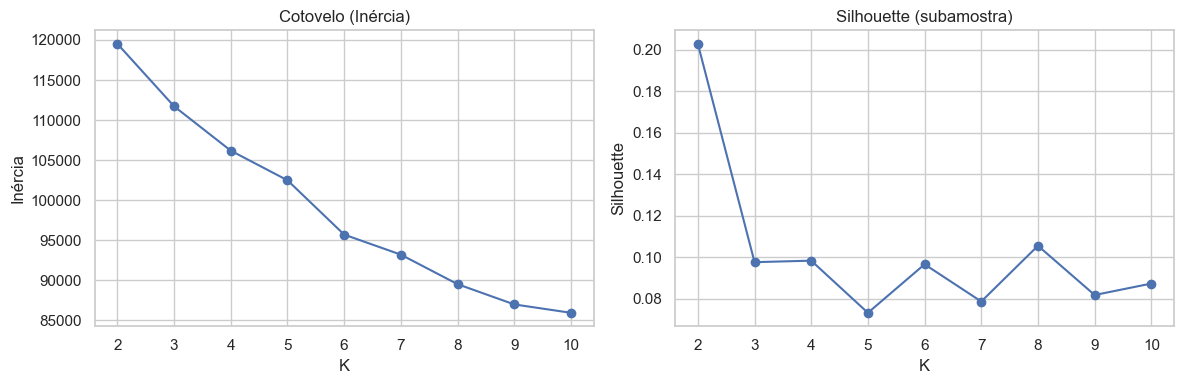

K escolhido (máx. silhouette): 2

Criação da feature de cluster (distância mínima ao centróide)
Formas → original: (20000, 16) | com feature: (20000, 17)

Treinando modelos (com e sem a feature)

Resultados: Sem feature de cluster


,accuracy,precision,recall,f1,auc_roc
svm_linear,0.222,0.199,0.222,0.202,0.887
svm_poly,0.231,0.231,0.231,0.218,0.900
svm_rbf,0.238,0.224,0.238,0.219,0.903
rf,0.318,0.306,0.318,0.305,0.913



Resultados: Com feature de cluster


,accuracy,precision,recall,f1,auc_roc
svm_linear,0.220,0.198,0.220,0.199,0.890
svm_poly,0.230,0.219,0.230,0.211,0.897
svm_rbf,0.232,0.211,0.232,0.209,0.899
rf,0.315,0.301,0.315,0.301,0.911



Avaliação: comparação direta das métricas (Com − Sem)


,accuracy_with,precision_with,recall_with,f1_with,auc_roc_with,accuracy_no,precision_no,recall_no,f1_no,auc_roc_no,Delta_F1
svm_linear,0.220,0.198,0.220,0.199,0.890,0.222,0.199,0.222,0.202,0.887,-0.003
rf,0.315,0.301,0.315,0.301,0.911,0.318,0.306,0.318,0.305,0.913,-0.004
svm_poly,0.230,0.219,0.230,0.211,0.897,0.231,0.231,0.231,0.218,0.900,-0.007
svm_rbf,0.232,0.211,0.232,0.209,0.899,0.238,0.224,0.238,0.219,0.903,-0.010


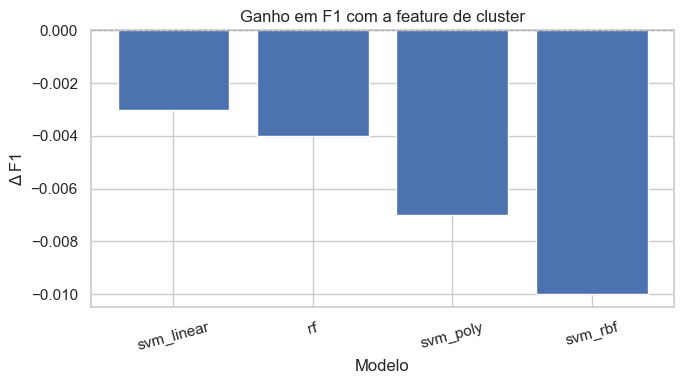

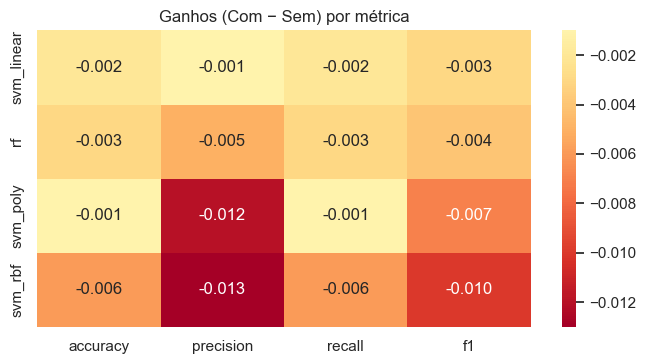

Problema multiclasse — ROC omitida (use AUC macro nas tabelas).

Influência do número de clusters: F1 (teste) vs K — SVM RBF (com feature)


,K,F1_test
0,2,0.208818
1,3,0.208812
2,4,0.212020
3,5,0.209785
4,6,0.212539
5,7,0.212067
6,8,0.211579
7,9,0.211504
8,10,0.213921


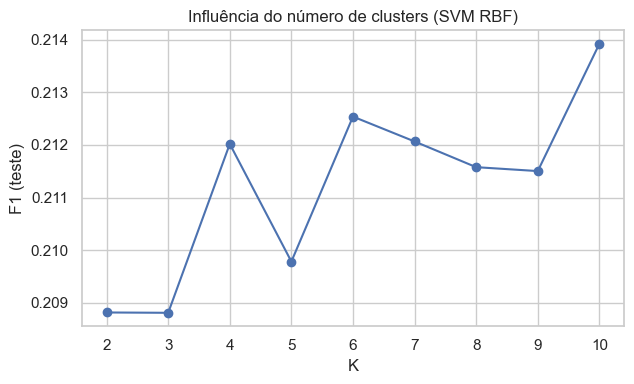

In [5]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve

DATA_PATH   = "dataset.csv"
TARGET_COL  = "track_genre"
K_RANGE     = range(2, 11)
SEED        = 42
SUBSAMPLE_K = 10_000
MAX_TRAIN   = 20_000
MAX_TEST    = 8_000
USE_MINIBATCH_FINAL = False

sns.set_theme(context="notebook", style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)
np.random.seed(SEED)

df = pd.read_csv(DATA_PATH)
drop_cols = [c for c in ["Unnamed: 0","track_id","artists","album_name","track_name"] if c in df.columns]
df = df.drop(columns=drop_cols)
assert TARGET_COL in df.columns, f"TARGET_COL='{TARGET_COL}' não encontrado."

y = df[TARGET_COL]
X = df.drop(columns=[TARGET_COL])

if y.dtype == "object":
    y = LabelEncoder().fit_transform(y)

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print(f"Shape completo: {df.shape} | Numéricas: {len(num_cols)} | Categóricas: {len(cat_cols)}")

Xtr_raw, Xte_raw, ytr_full, yte_full = train_test_split(
    X, y, test_size=0.25, random_state=SEED, stratify=y
)

# subamostragem estratificada controlada
def strat_subsample(X_df, y_vec, max_n, seed):
    if len(y_vec) <= max_n:
        return X_df, y_vec
    sss = StratifiedShuffleSplit(n_splits=1, train_size=max_n, random_state=seed)
    idx, _ = next(sss.split(np.zeros(len(y_vec)), y_vec))
    return X_df.iloc[idx], y_vec[idx]

Xtr_small, ytr = strat_subsample(Xtr_raw, ytr_full, MAX_TRAIN, SEED)
Xte_small, yte = strat_subsample(Xte_raw, yte_full, MAX_TEST,  SEED)
print(f"Subamostras estratificadas → Train: {Xtr_small.shape[0]} | Test: {Xte_small.shape[0]}")

try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

num_idx = [X.columns.get_loc(c) for c in num_cols]
cat_idx = [X.columns.get_loc(c) for c in cat_cols]

prep = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_idx),
        ("cat", ohe, cat_idx),
    ],
    remainder="drop", verbose_feature_names_out=False
)

Xtr = prep.fit_transform(Xtr_small)
Xte = prep.transform(Xte_small)
print(f"Shapes transformados → X_train: {Xtr.shape} | X_test: {Xte.shape}")

# Parte 1. Clusterização K-Médias
print("\nEscolha de K (MiniBatchKMeans + subamostra)")
n_sub = min(SUBSAMPLE_K, Xtr.shape[0])
idx = np.random.choice(Xtr.shape[0], size=n_sub, replace=False)
Xsub = Xtr[idx]

inertia, silh = [], []
for k in K_RANGE:
    mbk = MiniBatchKMeans(n_clusters=k, batch_size=1024, n_init=10, random_state=SEED)
    labels = mbk.fit_predict(Xsub)
    inertia.append(mbk.inertia_)
    silh.append(silhouette_score(Xsub, labels))

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(list(K_RANGE), inertia, marker="o")
ax[0].set_title("Cotovelo (Inércia)"); ax[0].set_xlabel("K"); ax[0].set_ylabel("Inércia")
ax[1].plot(list(K_RANGE), silh, marker="o")
ax[1].set_title("Silhouette (subamostra)"); ax[1].set_xlabel("K"); ax[1].set_ylabel("Silhouette")
plt.tight_layout(); plt.show()

best_k = list(K_RANGE)[int(np.argmax(silh))]
print(f"K escolhido (máx. silhouette): {best_k}")

kmodel = (MiniBatchKMeans(n_clusters=best_k, batch_size=2048, n_init=10, random_state=SEED)
          if USE_MINIBATCH_FINAL else
          KMeans(n_clusters=best_k, n_init=10, random_state=SEED)).fit(Xtr)

# Parte 2. Criação de Features
print("\nCriação da feature de cluster (distância mínima ao centróide)")
Dtr_all = kmodel.transform(Xtr)
Dte_all = kmodel.transform(Xte)
Xtr_aug = np.hstack([Xtr, Dtr_all.min(axis=1, keepdims=True)])
Xte_aug = np.hstack([Xte, Dte_all.min(axis=1, keepdims=True)])
print(f"Formas → original: {Xtr.shape} | com feature: {Xtr_aug.shape}")

# Parte 3. Modelo de ML
print("\nTreinando modelos (com e sem a feature)")
models = {
    "svm_linear": SVC(kernel="linear", C=1.0, probability=True, random_state=SEED),
    "svm_poly":   SVC(kernel="poly", degree=2, C=1.0, gamma="scale", probability=True, random_state=SEED),
    "svm_rbf":    SVC(kernel="rbf",  C=1.0, gamma="scale", probability=True, random_state=SEED),
    "rf":         RandomForestClassifier(n_estimators=300, random_state=SEED, n_jobs=-1),
}

def eval_model(clf, Xt, yt, Xv, yv):
    clf.fit(Xt, yt)
    yp = clf.predict(Xv)
    pro = clf.predict_proba(Xv) if hasattr(clf, "predict_proba") else None
    acc = accuracy_score(yv, yp)
    prec, rec, f1, _ = precision_recall_fscore_support(yv, yp, average="weighted", zero_division=0)
    out = {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}
    if pro is not None:
        out["auc_roc"] = (roc_auc_score(pd.get_dummies(yv), pro, average="macro", multi_class="ovr")
                          if len(np.unique(yv)) > 2 else roc_auc_score(yv, pro[:, -1]))
    return out, pro

res_no, res_yes, prob_yes = {}, {}, {}
for name, clf in models.items():
    res_no[name],  _     = eval_model(clf, Xtr,     ytr, Xte,     yte)
    res_yes[name], pro_y = eval_model(clf, Xtr_aug, ytr, Xte_aug, yte)
    prob_yes[name] = pro_y

df_no  = pd.DataFrame(res_no).T.round(3)
df_yes = pd.DataFrame(res_yes).T.round(3)
print("\nResultados: Sem feature de cluster");  display(df_no)
print("\nResultados: Com feature de cluster"); display(df_yes)

# Parte 4. Avaliação de Modelos
print("\nAvaliação: comparação direta das métricas (Com − Sem)")
cmp = df_yes.add_suffix("_with").join(df_no.add_suffix("_no"))
cmp["Delta_F1"] = cmp["f1_with"] - cmp["f1_no"]
cmp_ord = cmp.sort_values("Delta_F1", ascending=False)
display(cmp_ord.round(3))

# ΔF1 barplot
plt.figure(figsize=(7,4))
plt.bar(cmp_ord.index, cmp_ord["Delta_F1"])
plt.axhline(0, color="black", lw=0.8, ls="--")
plt.title("Ganho em F1 com a feature de cluster"); plt.ylabel("Δ F1"); plt.xlabel("Modelo")
plt.xticks(rotation=15); plt.tight_layout(); plt.show()

# heatmap de ganhos por métrica
met = ["accuracy","precision","recall","f1"]
gain = (df_yes[met] - df_no[met]).loc[cmp_ord.index]
plt.figure(figsize=(6.8,3.8))
sns.heatmap(gain, annot=True, fmt=".3f", cmap="RdYlGn", center=0)
plt.title("Ganhos (Com − Sem) por métrica")
plt.tight_layout(); plt.show()

# curvas ROC (binário)
if len(np.unique(yte)) == 2:
    plt.figure(figsize=(6,4))
    for name, pro in prob_yes.items():
        if pro is None: 
            continue
        fpr, tpr, _ = roc_curve(yte, pro[:, -1])
        plt.plot(fpr, tpr, label=name)
    plt.plot([0,1],[0,1],"--", color="gray", lw=0.8)
    plt.title("Curvas ROC (teste) — com feature de cluster")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
    plt.tight_layout(); plt.show()
else:
    print("Problema multiclasse — ROC omitida (use AUC macro nas tabelas).")

# Parte 5. Análise Comparativa
print("\nInfluência do número de clusters: F1 (teste) vs K — SVM RBF (com feature)")
f1_vs_k = []
for k in K_RANGE:
    km = MiniBatchKMeans(n_clusters=k, batch_size=2048, n_init=10, random_state=SEED).fit(Xtr)
    Dtr = km.transform(Xtr); Dte = km.transform(Xte)
    Xtr_aug_k = np.hstack([Xtr, Dtr.min(axis=1, keepdims=True)])
    Xte_aug_k = np.hstack([Xte, Dte.min(axis=1, keepdims=True)])

    clf = SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=SEED)
    clf.fit(Xtr_aug_k, ytr)
    ypk = clf.predict(Xte_aug_k)
    f1k = precision_recall_fscore_support(yte, ypk, average="weighted", zero_division=0)[2]
    f1_vs_k.append((k, f1k))

f1_df = pd.DataFrame(f1_vs_k, columns=["K","F1_test"])
display(f1_df)

plt.figure(figsize=(6.5,4))
plt.plot(f1_df["K"], f1_df["F1_test"], marker="o")
plt.title("Influência do número de clusters (SVM RBF)")
plt.xlabel("K"); plt.ylabel("F1 (teste)")
plt.tight_layout(); plt.show()